In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/apatania/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
import examples as eg
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [17]:
annulus = eg.annulus_variable_d_example()

## Step 2 - Computing VR and Cohomology

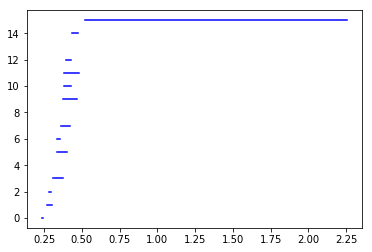

In [18]:
prime = 23 #choose the prime

vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)
dionysus.plot.plot_bars(dgms[1], show=True)

## Step 3 - Selecting the cocycle

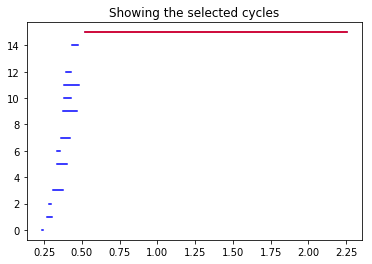

In [19]:
bars = [bar for bar in dgms[1] if bar.death-bar.birth > 1.] #choosing cocycle that persist at least 1.
cocycles = [cp.cocycle(bar.data) for bar in bars]

dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > 1.][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > 1.][0],'r')
plt.title('Showing the selected cycles')
plt.show()

In [20]:
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [21]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_8, chosen_cocycle, prime)

### Visualization

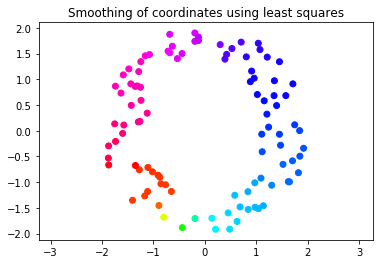

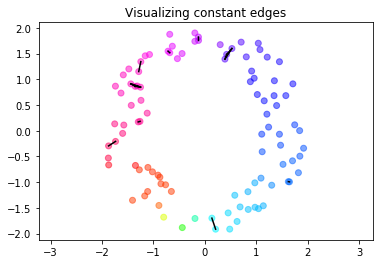

In [22]:
scatter(*annulus.T, c=coords, cmap="hsv")
plt.axis('equal')
plt.title('Smoothing of coordinates using least squares')
plt.show()

toll = 1e-5
p,val = (chosen_bar,coords)
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)        
scatter(*annulus.T, c=val, cmap="hsv", alpha=.5)
plot(*edges_costant.T, c='k')
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

## Step 5 - Second smoothing using a new cost function

In [23]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)

In [24]:
import cost_functions
from scipy.optimize import minimize
l= 1.
cost = lambda z: cost_functions.cost_interpolate(z, L= l, F= f, B= bdry)
grad = lambda z: cost_functions.grad_interpolate(z, L= l, F= f, B= bdry)

res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)
color = np.mod(res.x,1)

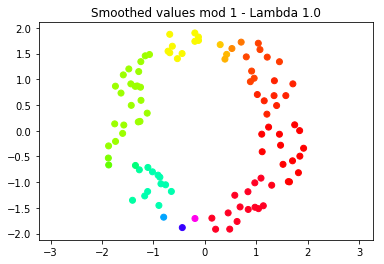

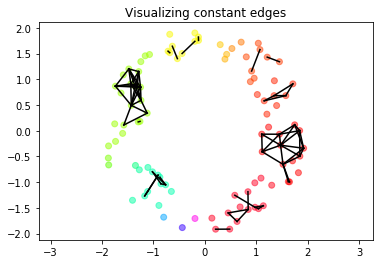

In [25]:
scatter(*annulus.T, c= color, cmap="hsv")
# plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - Lambda {}'.format(l))
plt.show()
toll = 1e-5
edges_costant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)        
scatter(*annulus.T, c=color, cmap="hsv", alpha=.5)
plot(*edges_costant.T, c='k')
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()